In [1]:
import sys
import logging

from my_minimal_example import main
%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

/volatile/home/pj273170/anaconda3/envs/breaching/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/volatile/home/pj273170/anaconda3/envs/breaching/lib/python3.9/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [8]:
from omegaconf import OmegaConf, open_dict
from breaching import get_config
import breaching

cfg = get_config(config_name="Adam_cfg")
print(OmegaConf.to_yaml(cfg))
with open_dict(cfg):
    cfg.case.model = "cifar10_mobilenet_v2"

model, loss_fn = breaching.cases.construct_model(cfg.case.model, cfg.case.data, cfg.case.server.pretrained)
# print(model)


Investigating use case image_custom with server type honest_but_curious.
case:
  data:
    db:
      name: null
    name: CIFAR10
    modality: vision
    task: classification
    path: ~/data
    size: 50000
    classes: 10
    shape:
    - 3
    - 32
    - 32
    normalize: true
    mean:
    - 0.4914672374725342
    - 0.4822617471218109
    - 0.4467701315879822
    std:
    - 0.24703224003314972
    - 0.24348513782024384
    - 0.26158785820007324
    augmentations_train:
      RandomCrop:
      - 32
      - 4
      RandomHorizontalFlip: 0.5
    augmentations_val: null
    default_clients: 10
    partition: random
    examples_from_split: validation
    batch_size: 128
    caching: false
  impl:
    shuffle: false
    sample_with_replacement: false
    dtype: float
    non_blocking: true
    sharing_strategy: file_descriptor
    enable_gpu_acc: true
    benchmark: true
    deterministic: false
    pin_memory: true
    threads: 0
    persistent_workers: false
    mixed_precision: fals

In [72]:
attacker, reconstructed_user_data, stats = main()

Loading attack configuration optimization-deep-leakage.
Attacker (of type OptimizationBasedAttacker) with settings:
    Hyperparameter Template: deep-leakage

    Objective: Euclidean loss with scale=1.0 and task reg=0.0
    Regularizers: 
    Augmentations: 

    Optimization Setup:
        optimizer: adam
        signed: None
        step_size: 0.1
        boxed: False
        max_iterations: 2400
        step_size_decay: None
        langevin_noise: 0.0
        warmup: 0
        grad_clip: None
        callback: 100
        
INFO:breaching.attacks.optimization_based_attack:| It: 1/2400 | Rec. loss: 12.3612 |  Task loss: 2.2611 | T: 0.02s
INFO:breaching.attacks.optimization_based_attack:| It: 101/2400 | Rec. loss: 0.1888 |  Task loss: 2.2973 | T: 2.40s
INFO:breaching.attacks.optimization_based_attack:| It: 201/2400 | Rec. loss: 0.1662 |  Task loss: 2.2982 | T: 2.30s
INFO:breaching.attacks.optimization_based_attack:| It: 301/2400 | Rec. loss: 0.1551 |  Task loss: 2.2987 | T: 2.20s
INF

[tensor(3), tensor(8), tensor(8), tensor(0)]


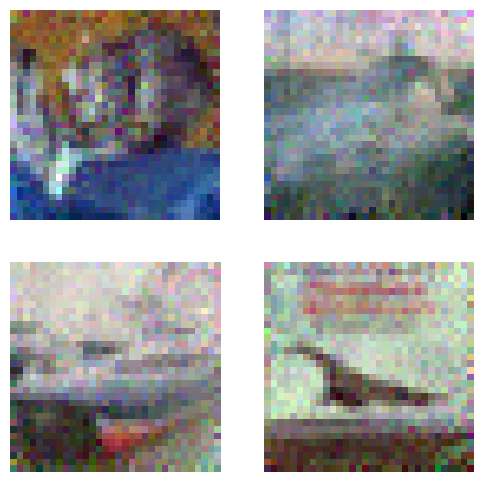

In [71]:
import torch

from my_minimal_example import data_cfg_default
import matplotlib.pyplot as plt
print_labels = True
scale = True
data, labels = reconstructed_user_data["data"], reconstructed_user_data["labels"]

dm = attacker.dm
ds = attacker.ds

if scale:
    min_val, max_val = data.amin(dim=[2, 3], keepdim=True), data.amax(dim=[2, 3], keepdim=True)
    # print(f'min_val: {min_val} | max_val: {max_val}')
    data = (data - min_val) / (max_val - min_val)
else:
    data.mul_(ds).add_(dm).clamp_(0, 1)
data = data.to(dtype=torch.float32)

grid_shape = int(torch.as_tensor(data.shape[0]).sqrt().ceil())
s = 24 if data.shape[3] > 150 else 6
fig, axes = plt.subplots(grid_shape, grid_shape, figsize=(s, s))
label_classes = []
for i, (im, axis) in enumerate(zip(data, axes.flatten())):
    axis.imshow(im.permute(1, 2, 0).cpu())
    if labels is not None and print_labels:
        label_classes.append(labels[i])
    axis.axis("off")
if print_labels:
    print(label_classes)